In [1]:
from PIL import Image
import numpy as np
import cv2
from scipy import signal as sig
from skimage.io import imread
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
from numpy import unravel_index
from HarrisDetection import harris_detection

In [2]:
''' # 
    # @desc apply Gaussian Bluring on a given image
    # @params np.array img: Image to apply Guassian on it
    # @returns np.array I: np.array of blured image
    #          np.array I_norm: normalized array between (0,255) for blured Image 
'''
def gaussian_blur_scipy(img):
    kernel = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
    I = sig.convolve2d(img, kernel, mode='same')/16.0
    I_norm = (I * 255 / I.max()).astype(np.uint8)
    return  I_norm

In [3]:
''' # 
    # @desc convert image to gray 
    # @params np.array img: Image to be converted to gray
    # @returns np.array gray image
'''
def imgtogray(img):
    img = np.array(img).astype('float64')
    img[:,:,0] *= 0.299
    img[:,:,1] *= 0.587
    img[:,:,2] *= 0.114
    return np.sum(img,axis=2).astype("uint8")

In [4]:
img = Image.open('Test_cow.jpg.png')

In [5]:
size = img.size
print(size)
ratio = 0.5
size = tuple([i*ratio for i in size])
print(size)
img.thumbnail(size,Image.ANTIALIAS)

(771, 495)
(385.5, 247.5)


In [6]:
images = np.array(img,size=(4,4))

TypeError: 'size' is an invalid keyword argument for array()

In [7]:
Images = np.repeat(img,16).reshape(img.size[1],img.size[0],3,4,4)

ValueError: cannot reshape array of size 6086080 into shape (247,385,3,4,4)

In [8]:
Images[:,:,:,i-1,0].shape

NameError: name 'Images' is not defined

In [9]:
images = [img]*20

In [10]:
img = Image.open('box.jpg')
img = img.convert('RGB')
img_gray = imgtogray(img)
images = [Image.fromarray(img_gray)]*20
images = np.array(images).reshape(4,5)

<ipython-input-10-48267c1dc86e>:5: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  images = np.array(images).reshape(4,5)
<ipython-input-10-48267c1dc86e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images).reshape(4,5)


In [11]:
ratio = 0.5
for i in range(images.shape[0]):
    if i != 0:
        size = images[i-1,0].size
        print("before",size)
        size = tuple([int(j*ratio) for j in size])
        print("after",size)
        images[i,0] = images[i,0].resize(size)
    for j in range(1,images.shape[1]):
        images[i,j] = Image.fromarray(gaussian_blur_scipy(np.array(images[i,j-1])))

before (454, 353)
after (227, 176)
before (227, 176)
after (113, 88)
before (113, 88)
after (56, 44)


In [12]:
DOG = np.empty((4,4),'object')

In [13]:
for i in range(images.shape[0]):
    for j in range(1,images.shape[1]):
        DOG[i,j-1] = np.abs(np.array(images[i,j-1]) - np.array(images[i,j]))

In [14]:
def check_point(image_border, images):
    if image_border%2 == 0:
        raise "window must be odd size"
    index = (image_border-1)//2
    middle_index = len(images)//2
    main_point = images[middle_index][index,index]
    global_max = True
    global_min = True
    for i in range(len(images)):
        if images[i].max()> main_point:
            global_max = False
        if images[i].min() < main_point:
            global_min = False
        if not(global_max or global_min):
            return None 
    if global_max : return 1
    else: return -1
    
    
    

In [15]:
DOG[octave_index,image_index-1][x-image_border:x,y-image_border,y]

NameError: name 'octave_index' is not defined

In [16]:
#here we should compare 2 succssisve images in the same scale and find maxima 
key_points = []
image_border = 3
for octave_index in range(DOG.shape[0]):
    for image_index in range(1,DOG[1].shape[0]-1):
        x_max, y_max = DOG[octave_index,image_index].shape[:2]
        for x in range(image_border,x_max-image_border):
            for y in range(image_border,y_max-image_border):
                sub_img_prev = DOG[octave_index,image_index-1][x-image_border:x,y-image_border:y]
                sub_img_main = DOG[octave_index,image_index][x-image_border:x,y-image_border:y]
                sub_img_next = DOG[octave_index,image_index+1][x-image_border:x,y-image_border:y]
                ret = check_point(image_border,[sub_img_prev,sub_img_main,sub_img_next])
                if ret != None : key_points.append([octave_index,image_index,x,y])

                
                


In [17]:
DOG[octave_index,image_index].shape

(44, 56)

In [29]:
high_contrast_key_points = []
for i in range(len(key_points)):
    octave_ind = key_points[i][0]
    image_ind = key_points[i][1]
    x = key_points[i][2]
    y = key_points[i][3]
    if DOG[octave_ind,image_ind][x,y] >(0.3*255):
        high_contrast_key_points.append([octave_ind,image_ind,x,y])

In [38]:
#step 4 eleminate edges (harris??) and low contrast 0.3[0,1]
harris_for_DOG = []
for octave_index in range(DOG.shape[0]):
    harris_per_octave = []
    for image_index in range(1,DOG[1].shape[0]-1):
        harris_per_octave.append(harris_detection(DOG[octave_index,image_index]))
    harris_for_DOG.append(harris_per_octave)

In [48]:
len(harris_for_DOG[0])

2

In [53]:
final_key_points = []
for i in range(len(high_contrast_key_points)):
    octave_ind = high_contrast_key_points[i][0]
    image_ind = high_contrast_key_points[i][1]
    x = high_contrast_key_points[i][2]
    y = high_contrast_key_points[i][3]
    if harris_for_DOG[octave_ind][image_ind-1][x,y] == 255:
        final_key_points.append([octave_ind,image_ind,x,y])
    

In [75]:
image_copy = np.array(img.copy())
count = 0
for i in final_key_points:
    if i[0] == 0:
        image_copy[i[2],i[3]] = [255,0,0]
        count += 1
        
len(final_key_points)

43

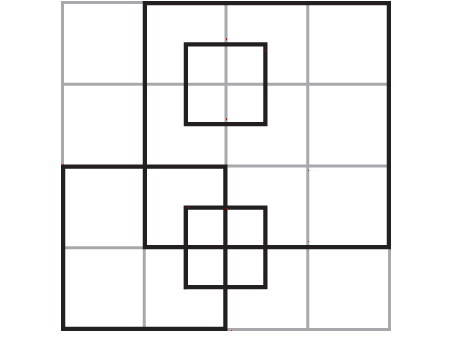

In [76]:
Image.fromarray(image_copy)

In [60]:
count

12

In [ ]:
#5. Orientation Assignment.
#6. Key-point description.

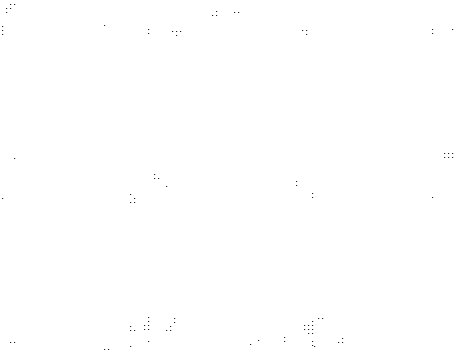

In [22]:
Image.fromarray(a,mode="LA")

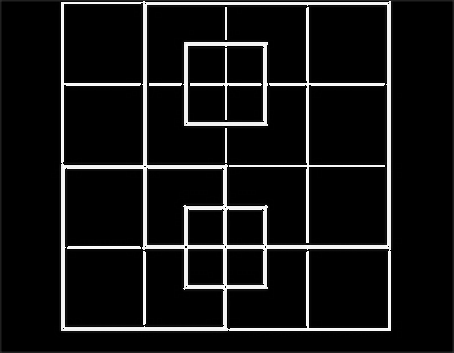

In [24]:
Image.fromarray(DOG[octave_index,image_index])